In [72]:
import os
import warnings
from dataclasses import dataclass, field
from datetime import datetime
from typing import Type

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter
from statsmodels.tsa.stattools import adfuller

from factories import date_month_dict
from functions import (date_treatment, plot_movie_type_distribution,
                       set_plot_style)
from utils_dataclasses import DataTreatment, LoadingData

warnings.filterwarnings('ignore')

set_plot_style()

In [2]:
loader_init = LoadingData(type_data='init_data')
treatment = DataTreatment(loader=loader_init,
                          FILENAME='critics.parquet')
dataset = treatment.data
dataset = treatment.init_treatment(data=dataset)
dataset = treatment.apply_rolling_per_group(data=dataset)
drop_duplicated_keys = ['date', 'types_movie']
dataset.drop_duplicates(subset=drop_duplicated_keys, inplace=True)

nrow, ncol = dataset.shape
print("Working Dataset Dimension:")
print("- {} rows".format(nrow))
print("- {} columns".format(ncol))

Working Dataset Dimension:
- 21345 rows
- 5 columns


In [56]:
dataset.head(10)

,critics,scores,date,types_movie,rolling_scores_30d
0,SuperGrave est une véritable comédie sur le su...,3,2014-09-01,Comédie,2.799257
1,Chevy Chase et Martin Short sont des purs prod...,3,2014-09-01,Aventure,2.912500
2,2 ans après un premier film sympathique mais q...,3,2014-09-01,Action,2.986532
4,"""Nos étoiles contraires"" est l’adaptation d’un...",4,2014-09-01,Romance,2.967742
7,Tout simplement magistral ! Avec comme tête d'...,4,2014-09-01,Thriller,2.858736
9,"Un film de science-fiction très réussi, fruit ...",4,2014-09-01,Science-Fiction,2.719697
12,Cela fait déjà un petit moment que DC Universe...,3,2014-09-01,Animation,2.961039
38,Un Twister revisité aux effets visuels d'aujou...,4,2014-09-02,Thriller,2.872727
39,Une bonne grosse pitrerie à la sauce Saturday ...,4,2014-09-02,Action,2.993377
40,"Lara Croft, l'héroïne Bad-Ass la plus sexy (et...",1,2014-09-02,Aventure,2.927273


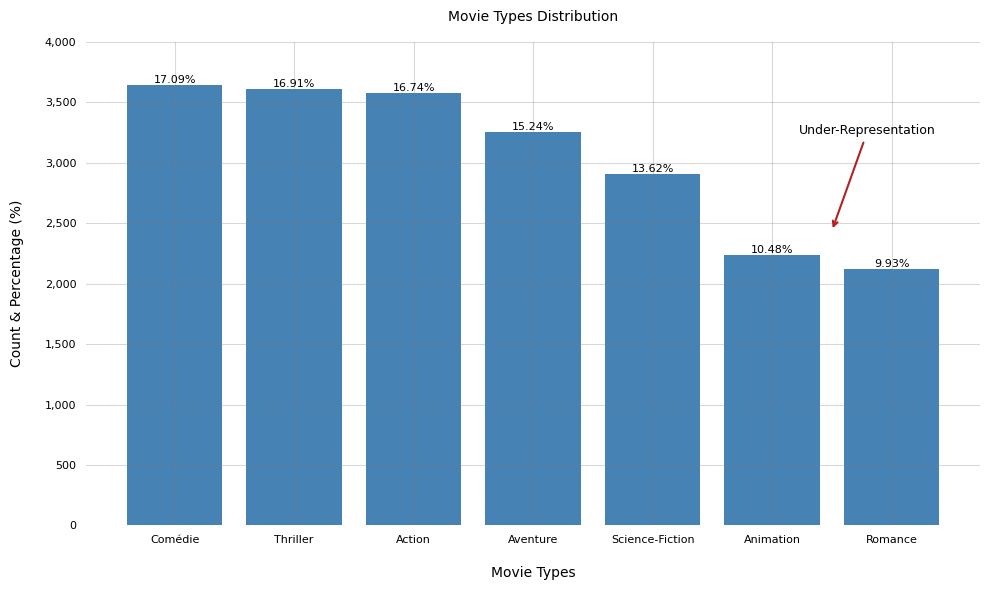

In [4]:
plot_movie_type_distribution(data=dataset)

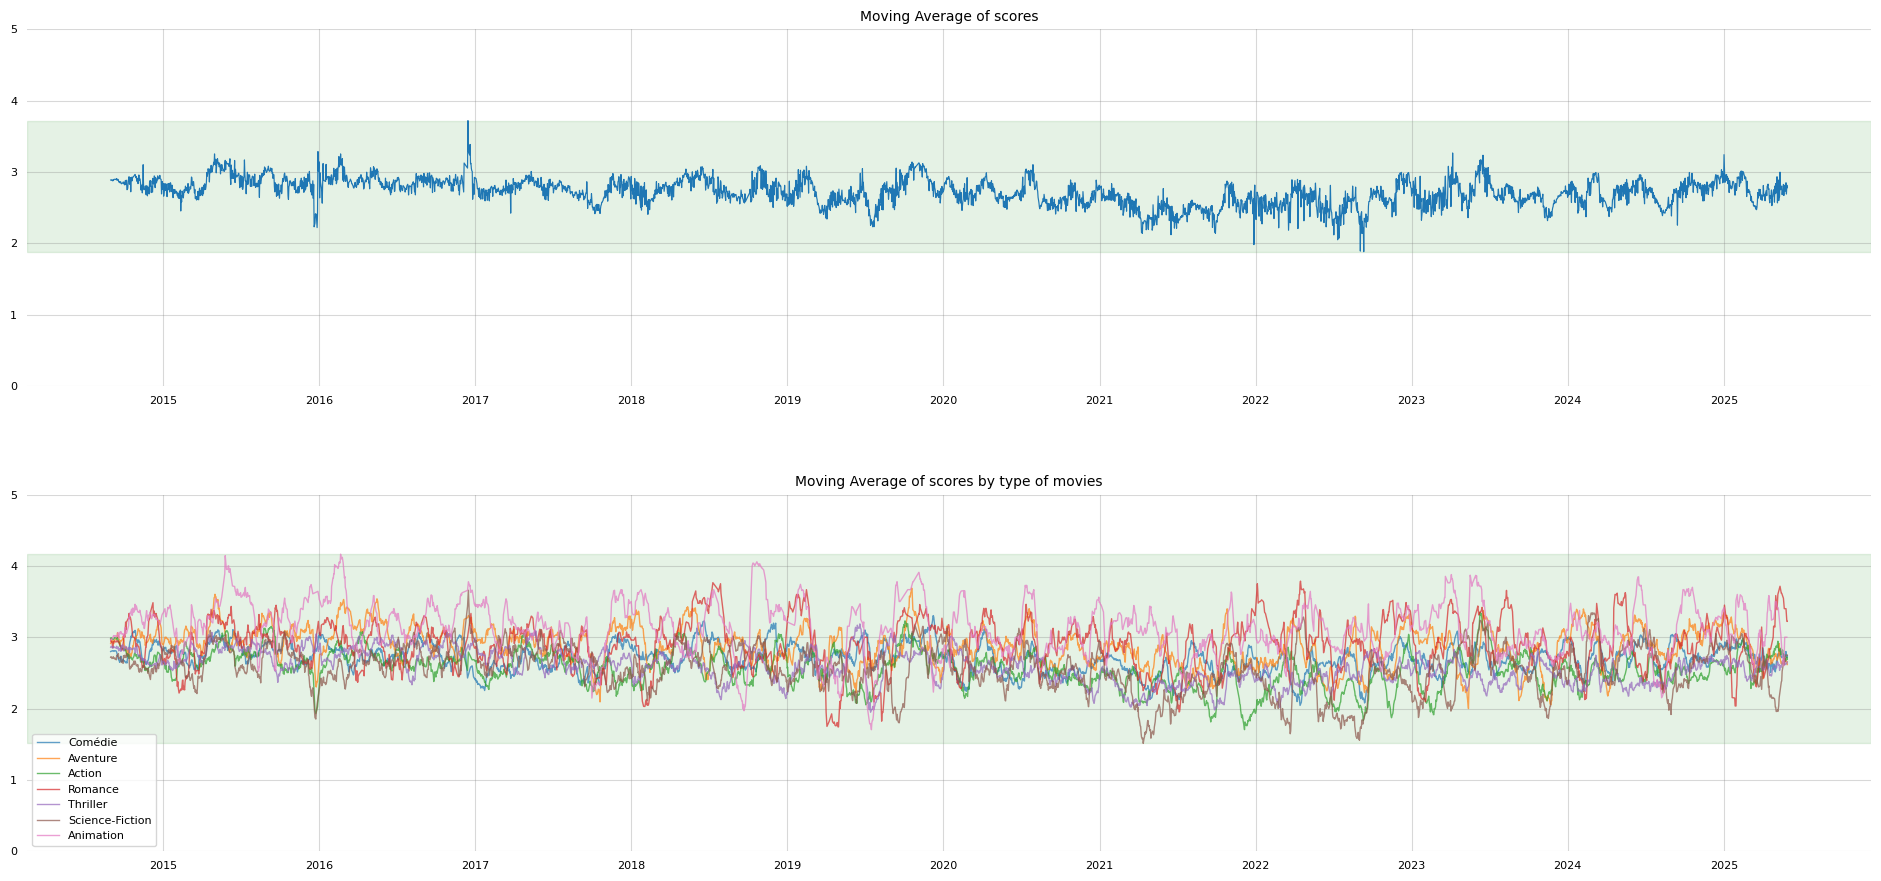

In [22]:
plt.figure(figsize=(20, 10))

unique_serie = dataset[['date', 'rolling_scores_30d']]
unique_serie = unique_serie.groupby('date', as_index=False)['rolling_scores_30d'].mean()

y_min1 = unique_serie['rolling_scores_30d'].min()
y_max1 = unique_serie['rolling_scores_30d'].max()

plt.subplot(2, 1, 1)
plt.plot(unique_serie['date'], unique_serie['rolling_scores_30d']
         , linewidth=0.85)
plt.axhspan(y_min1, y_max1, xmin=0, xmax=1, color='green', alpha=0.1)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylim([0, 5])
plt.title('Moving Average of scores', fontsize=10)

y_min2 = dataset['rolling_scores_30d'].min()
y_max2 = dataset['rolling_scores_30d'].max()

plt.subplot(2, 1, 2)
for type_ in dataset['types_movie'].unique():
    type_df = dataset[dataset['types_movie'] == type_]
    plt.plot(type_df['date'], type_df['rolling_scores_30d']
         , linewidth=1
         , alpha=0.7
         , label=type_)
plt.axhspan(y_min2, y_max2, xmin=0, xmax=1, color='green', alpha=0.1)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylim([0, 5])
plt.legend(fontsize=8)
plt.title('Moving Average of scores by type of movies', fontsize=10)

plt.tight_layout(pad=5)
plt.show()

In [43]:
from statsmodels.tsa.stattools import adfuller

serie = dataset[['date', 'rolling_scores_30d']].dropna()
serie = serie.set_index('date')
adf_result = adfuller(serie)
print(f"ADF p-value : {adf_result[1]:.4f}")

ADF p-value : 0.0000


In [70]:
def interpret_pvalue(pval: Type[float]) -> Type[str]:
    """
    Interpret the p-value of an ADF statistical test according to standard significance thresholds.

    Args:
        pval (float): The p-value from the ADF test.

    Returns:
        str: Textual interpretation of the p-value.
    """
    if pval < 0.01:
        return "Reject H0 at 1% → Stationary"
    elif pval < 0.05:
        return "Reject H0 at 5% → Stationary"
    elif pval < 0.10:
        return "Reject H0 at 10% → Stationary"
    else:
        return "Fail to reject H0 → Non-stationary"

def adf_test_summary(data: Type[pd.DataFrame]) -> Type[pd.DataFrame]:
    """
    Perform the Augmented Dickey-Fuller (ADF) stationarity test on the 
    'rolling_scores_30d' variable grouped by 'types_movie', and return a 
    summary dataframe including the test statistic, p-value (formatted 
    to 5 decimals), and interpretation.

    Args:
        data (DataFrame): DataFrame containing at least the columns
            'date', 'types_movie', and 'rolling_scores_30d'.

    Returns:
        pd.DataFrame: Summary DataFrame with columns:
            - 'Movie Types Series'
            - 'Statistics' (ADF statistic rounded to 5 decimals, string format)
            - 'P-value' (string format with 5 decimals)
            - 'Test Interpretation' (textual interpretation of the result)
    """
    stat_adf = []
    pval_adf = []
    test_interpretation = []
    movie_types_list = []

    features_for_adf = ['date', 'types_movie', 'rolling_scores_30d']
    df_for_adf_test = data[features_for_adf].copy()
    df_for_adf_test.set_index('date', inplace=True)

    for type_ in df_for_adf_test['types_movie'].unique():
        movie_type_subset = df_for_adf_test[df_for_adf_test['types_movie'] == type_]
        series = movie_type_subset['rolling_scores_30d'].dropna()

        adf_result = adfuller(series)
        stat_adf.append(f"{adf_result[0]:.5f}")
        pval_adf.append(f"{adf_result[1]:.5f}")
        test_interpretation.append(interpret_pvalue(adf_result[1]))
        movie_types_list.append(type_)

    summary_adf_results = pd.DataFrame({
        'Movie Types Series': movie_types_list,
        'Statistics': stat_adf,
        'P-value': pval_adf,
        'Test Interpretation': test_interpretation
    })

    return summary_adf_results

In [71]:
temp = adf_test_summary(data=dataset)